# Run MetaDetect on IMCOM

In [40]:
import os
from copy import deepcopy
import time
import joblib
from tqdm.notebook import tqdm
import s3fs

import numpy as np

from astropy.io import fits

import galsim

import ngmix
import metadetect

In [41]:
import matplotlib.pyplot as plt

### General config for Metadetect

In [918]:
# Size of the taget Gaussian PSF in IMCOM
PSF_FWHM = {
    "Y106": 0.22,
    "J129": 0.231,
    "H158": 0.242,
    "F184": 0.253,
    "K213": 0.264,
}
# Size of the image used to draw the PSF
PSF_IMG_SIZE = 151#*3

# Size of one IMCOM block
IMG_SIZE = 2688
#IMG_SIZE =1000
# Boundary used to avoid edge effects
# Objects for which the centre is within this distance from the edge will be
# masked out.
BOUND_SIZE = 100

METADETECT_CONFIG = {
    # Shape measurement method
    # wmom: weighted moments
    "model": "pgauss",

    # Size of the weight function for the moments
    'weight': {
        'fwhm': 1.2*5,#*5,  # arcsec
    },

    # Metacal settings
    'metacal': {
        'psf': 'fitgauss',
        # Kind of shear applied to the image
        'types': ['noshear', '1p', '1m', '2p', '2m'],
    },

    'sx': {
        # in sky sigma
        # DETECT_THRESH
        'detect_thresh': 1,

        # Minimum contrast parameter for deblending
        # DEBLEND_MINCONT
        'deblend_cont': 0.00001,

        # minimum number of pixels above threshold
        # DETECT_MINAREA: 6
        'minarea': 4,

        'filter_type': 'conv',

        # 7x7 convolution mask of a gaussian PSF with FWHM = 3.0 pixels.
        'filter_kernel': [
            [0.004963, 0.021388, 0.051328, 0.068707, 0.051328, 0.021388, 0.004963],  # noqa
            [0.021388, 0.092163, 0.221178, 0.296069, 0.221178, 0.092163, 0.021388],  # noqa
            [0.051328, 0.221178, 0.530797, 0.710525, 0.530797, 0.221178, 0.051328],  # noqa
            [0.068707, 0.296069, 0.710525, 0.951108, 0.710525, 0.296069, 0.068707],  # noqa
            [0.051328, 0.221178, 0.530797, 0.710525, 0.530797, 0.221178, 0.051328],  # noqa
            [0.021388, 0.092163, 0.221178, 0.296069, 0.221178, 0.092163, 0.021388],  # noqa
            [0.004963, 0.021388, 0.051328, 0.068707, 0.051328, 0.021388, 0.004963],  # noqa
        ]
    },

    # This is for the cutout at each detection
    'meds': {
        'min_box_size': 32,#*20,
        'max_box_size': 32*20,#*20,

        'box_type': 'iso_radius',

        'rad_min': 4,
        'rad_fac': 2,
        'box_padding': 2,
    },

    # check for an edge hit
    'bmask_flags': 2**30,

    'nodet_flags': 2**0,
}

### Set of funtions used to get the multiplicative bias

They are taken from:
- metadetect: https://github.com/esheldon/metadetect/blob/master/shear_meas_test/test_shear_meas.py
- descwl-shear-sims: https://github.com/LSSTDESC/descwl-shear-sims/blob/master/shear_meas_tests/test_shear_meas.py

They have been modified to apply the shear cancelation from IMCOM layers:
$$
\frac{\partial e_{1}}{\partial g_{1}} = m_{1} = \frac{2 \times \rm{layer7} - \rm{layer8} - \rm{layer9}}{3 \times 0.02}
$$
$$
\frac{\partial e_{2}}{\partial g_{2}} = m_{2} = \frac{\rm{layer8} - \rm{layer9}}{\sqrt{3} \times 0.02}
$$
We can also get the additive bias:
$$
c_{2} = \frac{\rm{layer8} + \rm{layer9}}{2}
$$

In [45]:
def _shear_cuts(arr, model):
    """
    Apply selection cuts + remove objects close to the edge.
    """
    if model == "wmom":
        tmin = 1.2
    else:
        tmin = 0.5

    buff_mask = (
        (arr["sx_col"] > BOUND_SIZE)
        & (arr["sx_col"] < IMG_SIZE-BOUND_SIZE) 
        & (arr["sx_row"] > BOUND_SIZE) 
        & (arr["sx_row"] < IMG_SIZE-BOUND_SIZE)
    )
    msk = (
        (arr[f'{model}_flags'] == 0)
        & (arr[f'{model}_s2n'] > 10)
        & (arr[f'{model}_T_ratio'] > tmin)
        & buff_mask
    )
    return msk

In [5]:
def _meas_shear_data(res, model):
    """
    Measure the shear response.
    """
    msk = _shear_cuts(res['noshear'], model)
    g1 = np.mean(res['noshear'][f'{model}_g'][msk, 0])
    g2 = np.mean(res['noshear'][f'{model}_g'][msk, 1])

    msk = _shear_cuts(res['1p'], model)
    g1_1p = np.mean(res['1p'][f'{model}_g'][msk, 0])
    msk = _shear_cuts(res['1m'], model)
    g1_1m = np.mean(res['1m'][f'{model}_g'][msk, 0])
    R11 = (g1_1p - g1_1m) / 0.02

    msk = _shear_cuts(res['2p'], model)
    g2_2p = np.mean(res['2p'][f'{model}_g'][msk, 1])
    msk = _shear_cuts(res['2m'], model)
    g2_2m = np.mean(res['2m'][f'{model}_g'][msk, 1])
    R22 = (g2_2p - g2_2m) / 0.02

    dt = [
        ('g1', 'f8'),
        ('g2', 'f8'),
        ('R11', 'f8'),
        ('R22', 'f8')]
    return np.array([(g1, g2, R11, R22)], dtype=dt)

In [6]:
def _bootstrap_stat(d1, d2, d3, func, seed, nboot=500):
    """
    Bootstrap data to get mean m-bias and associated error.
    """
    dim = d1.shape[0]
    rng = np.random.RandomState(seed=seed)
    stats = []
    for _ in range(nboot):
        ind = rng.choice(dim, size=dim, replace=True)
        stats.append(func(d1[ind], d2[ind], d3[ind]))
    return stats

In [7]:
def meas_m_c_cancel(res7, res8, res9):
    x = np.mean(2*res7['g1'] - res8['g1'] - res9['g1'])/3
    y = np.mean(res7['R11'] + res8['R11'] + res9['R11'])/3
    m1 = x/y/0.02 - 1

    x = np.mean(res8["g2"] - res9["g2"])/np.sqrt(3)
    y = np.mean(res8['R22'] + res9['R22'])/2
    m2 = x/y/0.02 - 1

    x = np.mean(res8['g2'] + res9['g2'])/2
    y = np.mean(res8['R22'] + res9['R22'])/2
    c = x/y

    return m1, m2, c

In [8]:
def boostrap_m_c(res7, res8, res9):
    m1, m2, c = meas_m_c_cancel(res7, res8, res9)
    bdata = _bootstrap_stat(res7, res8, res9, meas_m_c_cancel, 14324, nboot=500)
    m1err, m2err, cerr = np.std(bdata, axis=0)
    return m1, m1err, m2, m2err, c, cerr

In [9]:
def run_sim(img_path, seed, mdet_seed, model, band="H158"):
    """
    Recover the IMCOM image from `aws` and run metadection.
    """
    rng = np.random.RandomState(seed=seed)
    cfg = deepcopy(METADETECT_CONFIG)
    cfg["model"] = model
    
    # Read image
    with fits.open("s3://" + img_path, fsspec_kwargs={"anon": True}) as hdul:
        f = hdul[0].section[0, 0:1]
        h = hdul[0].header

    # Make WCS
    h.pop("NAXIS3")
    h.pop("NAXIS4")
    h["NAXIS"] = 2
    w = galsim.AstropyWCS(header=h)
    img_jacobian = w.jacobian(image_pos=galsim.PositionD(h["CRPIX1"], h["CRPIX2"]))

    # Make noise
    noise_sigma = 10
    noise = rng.normal(size=(IMG_SIZE, IMG_SIZE)) * noise_sigma

    # Make PSF
    psf = galsim.Gaussian(fwhm=PSF_FWHM[band])
    psf_img = psf.drawImage(
        nx=PSF_IMG_SIZE,
        ny=PSF_IMG_SIZE,
        wcs=w,
    ).array

    # Make NGmix jacobian
    psf_cen = (PSF_IMG_SIZE - 1) / 2
    img_cen = (np.array([IMG_SIZE, IMG_SIZE]) - 1) / 2

    psf_jac = ngmix.Jacobian(
        row=psf_cen,
        col=psf_cen,
        wcs=img_jacobian,
    )
    img_jac = ngmix.Jacobian(
        row=img_cen[0],
        col=img_cen[1],
        wcs=img_jacobian,
    )

    # Make PSF observation
    psf_obs = ngmix.Observation(
        image=psf_img,
        jacobian=psf_jac,
    )

    # Make obs
    res_layers = []
    for i in range(3):
        obs = ngmix.Observation(
            image=f[0 + i],
            jacobian=img_jac,
            weight=np.ones((IMG_SIZE, IMG_SIZE), dtype=float) / noise_sigma**2,
            psf=psf_obs,
            ormask=np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.int32),
            bmask=np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.int32),
        )

        obslist = ngmix.ObsList()
        obslist.append(obs)
        mbobs = ngmix.MultiBandObsList()
        mbobs.append(obslist)

        res = metadetect.do_metadetect(
            deepcopy(cfg),
            mbobs=mbobs,
            rng=np.random.RandomState(seed=mdet_seed),
        )
        res_layers.append(res)

    return _meas_shear_data(res_layers[0], model), _meas_shear_data(res_layers[1], model), _meas_shear_data(res_layers[2], model)


# Check an image

In [242]:
from astropy.wcs import WCS

In [10]:
# Setup the filesystem
fs = s3fs.S3FileSystem(anon=True)

In [11]:
# Path to the IMCOM coadds on AWS S3
coadd_dir = "nasa-irsa-simulations/openuniverse2024/roman/preview/RomanWAS/images/coadds"

In [12]:
band = "H158"

In [13]:
band_dir = os.path.join(coadd_dir, band)

In [14]:
subdirs = fs.ls(band_dir)

In [238]:
row_ind = 0
img_dir = subdirs[row_ind]

In [239]:
imgs = fs.ls(img_dir)

In [641]:
# Read an image and load only the layers we need
with fits.open("s3://" + imgs[1], fsspec_kwargs={"anon": True}) as hdul:
    f = hdul[0].section[0, 0:2]
    h = hdul[0].header

In [642]:
#dir(w)

In [643]:
h.pop("NAXIS3")
h.pop("NAXIS4")
h["NAXIS"] = 2
w = galsim.AstropyWCS(header=h)

In [644]:
img_jacobian = w.jacobian(image_pos=galsim.PositionD(h["CRPIX1"], h["CRPIX2"]))

In [645]:
## This sets the noise (determined somewhat empirically). Does not add noise to SCI image
rng = np.random.RandomState(42)
noise_sigma = 10#1e-4
noise = rng.normal(size=(IMG_SIZE, IMG_SIZE)) * noise_sigma

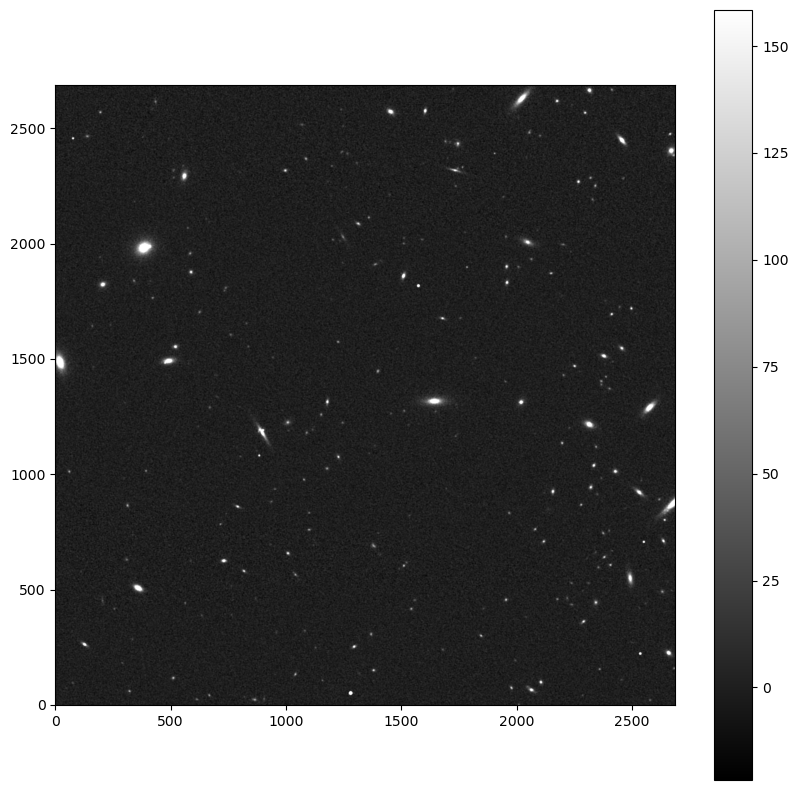

In [810]:
plt.figure(figsize=(10, 10))
img = f[0][:IMG_SIZE, :IMG_SIZE] #+ noise
m_img = np.mean(img)
s_img = np.std(img)
plt.imshow(img, origin='lower', cmap='gray', vmin=max(np.min(img), m_img - 5 * s_img), vmax=m_img + 5 * s_img)
plt.colorbar()
plt.show()

In [647]:
psf = galsim.Gaussian(fwhm=PSF_FWHM[band])
psf_img = psf.drawImage(
    nx=PSF_IMG_SIZE,
    ny=PSF_IMG_SIZE,
    wcs=w,
).array

In [890]:
psf_cen = (PSF_IMG_SIZE - 1) / 2
img_cen = (np.array([IMG_SIZE, IMG_SIZE]) - 1) / 2

psf_jac = ngmix.Jacobian(
    row=psf_cen,
    col=psf_cen,
    wcs=img_jacobian,
)
img_jac = ngmix.Jacobian(
    row=img_cen[0],
    col=img_cen[1],
    wcs=img_jacobian,
)

psf_obs = ngmix.Observation(
    image=psf_img,
    jacobian=psf_jac,
)

obs = ngmix.Observation(
    image=f[0][:IMG_SIZE, :IMG_SIZE], # + noise,
    jacobian=img_jac,
    weight=np.ones((IMG_SIZE, IMG_SIZE), dtype=float) / noise_sigma**2,
    psf=psf_obs,
    ormask=np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.int32),
    bmask=np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.int32),
)

obslist = ngmix.ObsList()
obslist.append(obs)
mbobs = ngmix.MultiBandObsList()
mbobs.append(obslist)

In [919]:
res = metadetect.do_metadetect(
    deepcopy(METADETECT_CONFIG),
    mbobs=mbobs,
    rng=np.random.RandomState(42),
)

In [907]:
res["noshear"].size

424

In [908]:
## Use this to see the columns in the sheared catalogs
res['noshear'].dtype.names

('pgauss_flags',
 'pgauss_psf_flags',
 'pgauss_psf_g',
 'pgauss_psf_T',
 'pgauss_obj_flags',
 'pgauss_s2n',
 'pgauss_g',
 'pgauss_g_cov',
 'pgauss_T',
 'pgauss_T_flags',
 'pgauss_T_err',
 'pgauss_T_ratio',
 'pgauss_band_flux_flags',
 'pgauss_band_flux',
 'pgauss_band_flux_err',
 'shear_bands',
 'sx_row',
 'sx_col',
 'sx_row_noshear',
 'sx_col_noshear',
 'ormask',
 'mfrac',
 'bmask',
 'mfrac_img',
 'ormask_noshear',
 'mfrac_noshear',
 'bmask_noshear',
 'det_bands',
 'psfrec_flags',
 'psfrec_g',
 'psfrec_T')

In [920]:
## Cuts
buff_mask = (res["noshear"]["sx_col"] > BOUND_SIZE) & (res["noshear"]["sx_col"] < IMG_SIZE-BOUND_SIZE) & \
            (res["noshear"]["sx_row"] > BOUND_SIZE) & (res["noshear"]["sx_row"] < IMG_SIZE-BOUND_SIZE)
#m_good = (res["noshear"]["pgauss_s2n"] > 10) & (res["noshear"]["pgauss_T_ratio"] > 0.5) & (res["noshear"]["pgauss_flags"] == 0) & buff_mask
m_good =  buff_mask

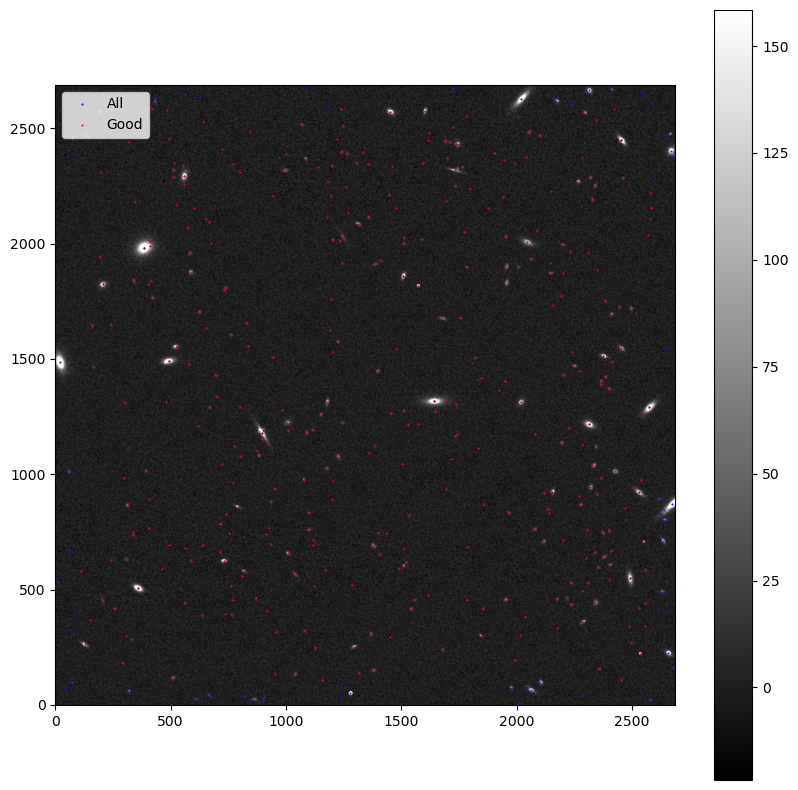

In [894]:
plt.figure(figsize=(10, 10))
img = f[0][:IMG_SIZE, :IMG_SIZE]  #+ noise
m_img = np.mean(img)
s_img = np.std(img)
plt.imshow(img, origin='lower', cmap='gray', vmin=max(np.min(img), m_img - 5 * s_img), vmax=m_img + 5 * s_img)
plt.plot(res["noshear"]["sx_col"], res["noshear"]["sx_row"], "b.", label="All", markersize = 1)
plt.plot(res["noshear"]["sx_col"][m_good], res["noshear"]["sx_row"][m_good], "r.", label="Good", markersize = 1)
plt.colorbar()
plt.legend(loc = 'upper left')
plt.show()

/tmp/ipykernel_655251/609828349.py:8: RuntimeWarning: invalid value encountered in log10
  mags_meas = -2.5*np.log10(flux_meas) + zp


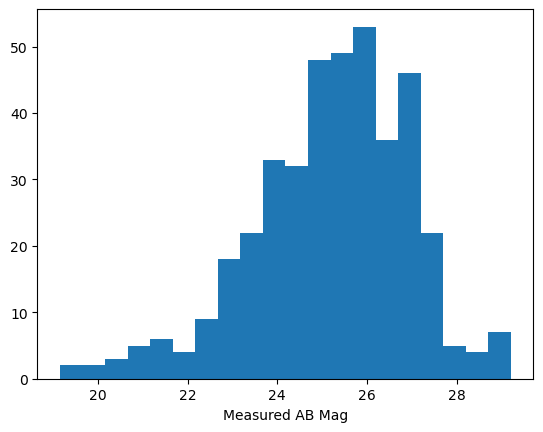

In [921]:
## Measured flux

ovsersample_pix = 0.039
norm_fact = roman.exptime*roman.collecting_area*(0.11**2/ovsersample_pix**2) # get flux in same units as truth catalog
roman_bandpasses = galsim.roman.getBandpasses()
zp = roman_bandpasses['H158'].zeropoint
flux_meas = res['noshear']['pgauss_band_flux']/norm_fact
mags_meas = -2.5*np.log10(flux_meas) + zp

plt.hist(mags_meas, bins = 20)
plt.xlabel('Measured AB Mag')
plt.show()

## Matching photometry to truth catalogs from simulation

In [896]:
import galsim.roman as roman
import healpy as hp
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

In [10]:


def radec_to_healpix(ra_deg, dec_deg, nside, nest=False):
    """
    Convert RA and DEC (in degrees) to HEALPix pixel index.
    """
    ra_deg = np.asarray(ra_deg)
    dec_deg = np.asarray(dec_deg)

    theta = np.radians(90.0 - dec_deg)  
    phi = np.radians(ra_deg)            

    pix = hp.ang2pix(nside, theta, phi, nest=nest)
    return pix


def match_catalog(detect_ra, detect_dec, catalog_ra, catalog_dec):
    """
    Match detected sources to the nearest entry in a reference catalog.
    Returns:
    indices :Indices in the catalog that best match each detection.
    distances_arcsec : Angular distance to the nearest catalog entry in arcseconds.
    """
    # Create SkyCoord objects
    coords_detect = SkyCoord(detect_ra, detect_dec, unit="deg")
    coords_catalog = SkyCoord(catalog_ra, catalog_dec, unit="deg")

    # Match each detection to the closest catalog source
    idx, d2d, _ = coords_detect.match_to_catalog_sky(coords_catalog)

    return idx, d2d.arcsec

In [11]:
## Read catalog and fluxes from truth catalog
flux_file = "nasa-irsa-simulations/openuniverse2024/roman/preview/roman_rubin_cats_v1.1.2_faint/galaxy_flux_10307.parquet"
cat_file = "nasa-irsa-simulations/openuniverse2024/roman/preview/roman_rubin_cats_v1.1.2_faint/galaxy_10307.parquet"

cat = pd.read_parquet(
    "s3://" + cat_file,
    engine="pyarrow",  # or "fastparquet"
    storage_options={"anon": True}  # set to False and provide credentials if needed
)

flux_cat = pd.read_parquet(
    "s3://" + flux_file,
    engine="pyarrow",  # or "fastparquet"
    storage_options={"anon": True}  # set to False and provide credentials if needed
)

cat_ra, cat_dec = cat['ra'], cat['dec']

In [922]:
## Since we are working on the preview area, we already know what healpy pixel the data falls in, but in case you want
## to work with the full data, hp_pix can help you know which healpy pixel your data falls in to fetch appropiate data

x, y = res["noshear"]["sx_col"], res["noshear"]["sx_row"]
ra_pos, dec_pos = w.toWorld(x,y, units='deg') # convert pixel positions to RA,DEC
hp_pix = radec_to_healpix(ra_pos, dec_pos, 32)

In [923]:
# Get matched positions
matched_idx, err_dist = match_catalog(ra_pos, dec_pos, cat_ra, cat_dec)

In [924]:
flux_true = np.array(flux_cat['roman_flux_H158'])[matched_idx]
mag_true = -2.5*np.log10(flux_true) + zp

In [925]:
#plt.hist((flux_meas/flux_true) - 1, range = (-2,2))
#plt.show()

In [926]:
#np.nanmedian(flux_meas/flux_test - 1), np.nanmedian(flux_meas)/np.median(flux_test) - 1

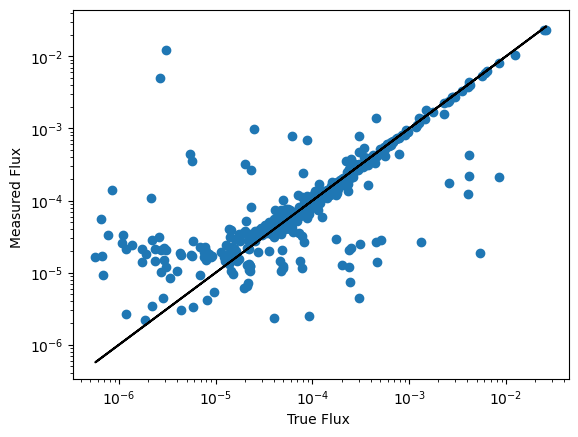

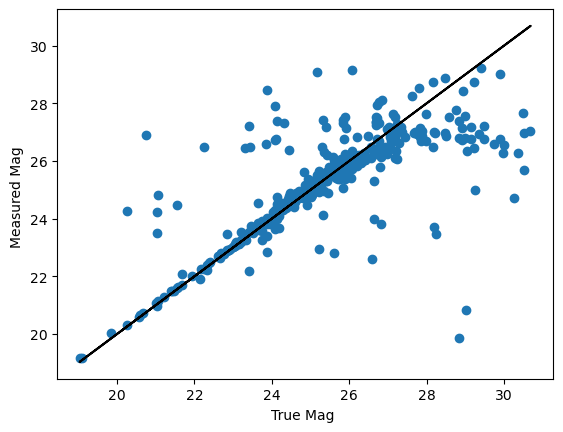

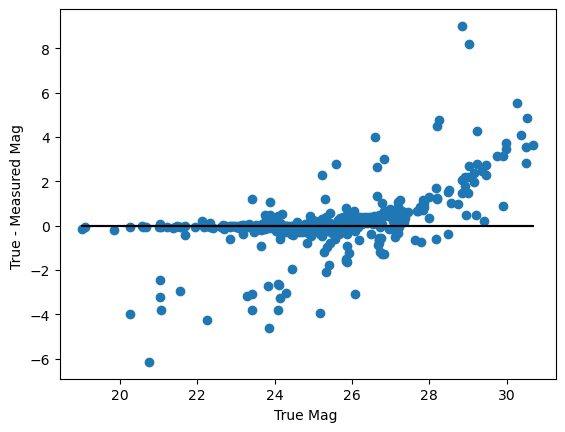

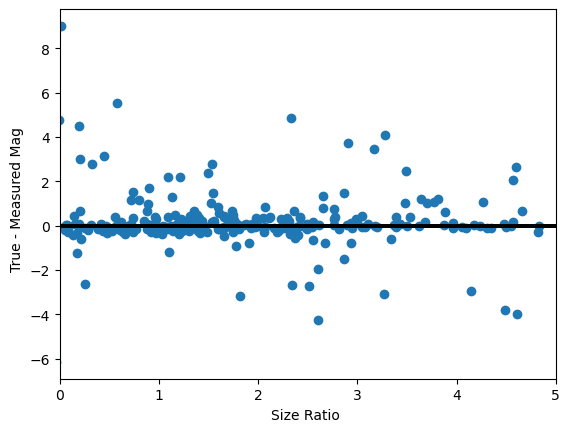

In [927]:
plt.scatter(flux_true, flux_meas)
plt.plot(flux_true,flux_true,color = 'black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('True Flux ')
plt.ylabel('Measured Flux ')
plt.show()

plt.scatter(mag_true, mags_meas )
plt.plot(mag_true,mag_true,color = 'black')
plt.xlabel('True Mag ')
plt.ylabel('Measured Mag ')
plt.show()

plt.scatter(mag_true,mag_true -  mags_meas )
plt.plot(mag_true,mag_true*0,color = 'black')

plt.xlabel('True Mag ')
plt.ylabel('True - Measured Mag ')
plt.show()

plt.scatter(res['noshear']["pgauss_T_ratio"],mag_true -  mags_meas )
plt.plot(res['noshear']["pgauss_T_ratio"],mag_true*0,color = 'black')
plt.xlim(0,5)
plt.xlabel('Size Ratio ')
plt.ylabel('True - Measured Mag  ')
plt.show()


In [819]:
#-2.5*np.log10(0.11**2)

## Process all

## Make Single Catalog

In [3]:
## Imports in case you want to start here
import os
from copy import deepcopy
import time
import joblib
from tqdm.notebook import tqdm
import s3fs
import numpy as np
from astropy.io import fits
import galsim
import ngmix
import metadetect
from astropy.wcs import WCS
import galsim.roman as roman
import healpy as hp
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

/hildafs/projects/phy200017p/berlfein/miniconda3/envs/tutorial_metadetect/lib/python3.13/site-packages/metadetect/fitting.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


### meta config

In [5]:
# Size of the taget Gaussian PSF in IMCOM
PSF_FWHM = {
    "Y106": 0.22,
    "J129": 0.231,
    "H158": 0.242,
    "F184": 0.253,
    "K213": 0.264,
}
# Size of the image used to draw the PSF
PSF_IMG_SIZE = 151#*3

# Size of one IMCOM block
IMG_SIZE = 2688
#IMG_SIZE =1000
# Boundary used to avoid edge effects
# Objects for which the centre is within this distance from the edge will be
# masked out.
BOUND_SIZE = 100

METADETECT_CONFIG = {
    # Shape measurement method
    # wmom: weighted moments
    "model": "pgauss",

    # Size of the weight function for the moments
    'weight': {
        'fwhm': 1.2*5,  # arcsec
    },

    # Metacal settings
    'metacal': {
        'psf': 'fitgauss',
        # Kind of shear applied to the image
        'types': ['noshear', '1p', '1m', '2p', '2m'],
    },

    'sx': {
        # in sky sigma
        # DETECT_THRESH
        'detect_thresh': 1,

        # Minimum contrast parameter for deblending
        # DEBLEND_MINCONT
        'deblend_cont': 0.00001,

        # minimum number of pixels above threshold
        # DETECT_MINAREA: 6
        'minarea': 4,

        'filter_type': 'conv',

        # 7x7 convolution mask of a gaussian PSF with FWHM = 3.0 pixels.
        'filter_kernel': [
            [0.004963, 0.021388, 0.051328, 0.068707, 0.051328, 0.021388, 0.004963],  # noqa
            [0.021388, 0.092163, 0.221178, 0.296069, 0.221178, 0.092163, 0.021388],  # noqa
            [0.051328, 0.221178, 0.530797, 0.710525, 0.530797, 0.221178, 0.051328],  # noqa
            [0.068707, 0.296069, 0.710525, 0.951108, 0.710525, 0.296069, 0.068707],  # noqa
            [0.051328, 0.221178, 0.530797, 0.710525, 0.530797, 0.221178, 0.051328],  # noqa
            [0.021388, 0.092163, 0.221178, 0.296069, 0.221178, 0.092163, 0.021388],  # noqa
            [0.004963, 0.021388, 0.051328, 0.068707, 0.051328, 0.021388, 0.004963],  # noqa
        ]
    },

    # This is for the cutout at each detection
    'meds': {
        'min_box_size': 32,#*20,
        'max_box_size': 32*20,#*20,

        'box_type': 'iso_radius',

        'rad_min': 4,
        'rad_fac': 2,
        'box_padding': 2,
    },

    # check for an edge hit
    'bmask_flags': 2**30,

    'nodet_flags': 2**0,
}

### functions

In [107]:
def make_mbobs(image,psf, wcs, noise_sigma, img_jacobian):
    psf_img = psf.drawImage(
        nx=PSF_IMG_SIZE,
        ny=PSF_IMG_SIZE,
        wcs=wcs,
    ).array

    # Make NGmix jacobian
    psf_cen = (PSF_IMG_SIZE - 1) / 2
    img_cen = (np.array([IMG_SIZE, IMG_SIZE]) - 1) / 2

    psf_jac = ngmix.Jacobian(
        row=psf_cen,
        col=psf_cen,
        wcs=img_jacobian,
    )
    img_jac = ngmix.Jacobian(
        row=img_cen[0],
        col=img_cen[1],
        wcs=img_jacobian,
    )

    # Make PSF observation
    psf_obs = ngmix.Observation(
        image=psf_img,
        jacobian=psf_jac,
    )

    obs = ngmix.Observation(
            image= image,
            jacobian=img_jac,
            weight=np.ones((IMG_SIZE, IMG_SIZE), dtype=float) / noise_sigma**2,
            psf=psf_obs,
            ormask=np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.int32),
            bmask=np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.int32),
        )
    obslist = ngmix.ObsList()
    obslist.append(obs)
    mbobs = ngmix.MultiBandObsList()
    mbobs.append(obslist)
    return mbobs

def get_block_image(image_path):
    # Read images from preview folder
    with fits.open("s3://" + image_path, fsspec_kwargs={"anon": True}) as hdul:
        f = hdul[0].section[0, 0:1]
        h = hdul[0].header

    return f[0], h
def get_photometry(flux_imcom, band):
    oversample_pix = 0.039
    pix_size = 0.11
    norm_fact = roman.exptime*roman.collecting_area*(pix_size**2/oversample_pix**2) # get flux in same units as truth catalog
    roman_bandpasses = galsim.roman.getBandpasses()
    zp = roman_bandpasses[band].zeropoint
    flux_meas = flux_imcom/norm_fact
    mags_meas = -2.5*np.log10(flux_meas) + zp
    return flux_meas, mags_meas

def _match_meta_fluxes_from_image(image_path, mdet_seed, model, cat_pos, band="H158", usecfg = 'default', keepcols = None):
    """
    Recover the IMCOM image from `aws` and run metadection.
    """
    if usecfg == 'default':
        cfg = deepcopy(METADETECT_CONFIG)
    else: 
        cfg = usecfg
    cfg["model"] = model

    if keepcols is None:
        keepcols = ['flags', 's2n', 'band_flux_flags']
    
    
    # Read images from preview folder
    image, h = get_block_image(image_path)

    # Make WCS from image header
    h.pop("NAXIS3")
    h.pop("NAXIS4")
    h["NAXIS"] = 2
    wcs = galsim.AstropyWCS(header=h)
    img_jacobian = wcs.jacobian(image_pos=galsim.PositionD(h["CRPIX1"], h["CRPIX2"]))

    # Estimate of the image noise
    noise_sigma = 10

    # Make PSF
    psf = galsim.Gaussian(fwhm=PSF_FWHM[band])
    #Create ngmix observations
    mbobs = make_mbobs(image,psf, wcs, noise_sigma, img_jacobian)

    
    # Run metadetect
    res = metadetect.do_metadetect(
        deepcopy(cfg),
        mbobs=mbobs,
        rng=np.random.RandomState(seed=mdet_seed),
    )

    flux_imcom = res['noshear']['pgauss_band_flux']
    flux_meas, mags_meas = get_photometry(flux_imcom, band)

    ## Since we are working on the preview area, we already know what healpy pixel the data falls in, but in case you want
    ## to work with the full data, hp_pix can help you know which healpy pixel your data falls in to fetch appropiate data
    x, y = res["noshear"]["sx_col"], res["noshear"]["sx_row"]
    ra_pos, dec_pos = wcs.toWorld(x,y, units='deg') # convert pixel positions to RA,DEC
    hp_pix = radec_to_healpix(ra_pos, dec_pos, 32)


    # Get matched positions
    cat_ra, cat_dec = cat_pos['ra'], cat_pos['dec']
    matched_idx, err_dist = match_catalog(ra_pos, dec_pos, cat_ra, cat_dec)

    #flux_true = np.array(flux_cat['roman_flux_H158'])[matched_idx]
    #mag_true = -2.5*np.log10(flux_true) + zp

    buff_mask = (res["noshear"]["sx_col"] > BOUND_SIZE) & (res["noshear"]["sx_col"] < IMG_SIZE-BOUND_SIZE) & \
            (res["noshear"]["sx_row"] > BOUND_SIZE) & (res["noshear"]["sx_row"] < IMG_SIZE-BOUND_SIZE)

    buff_mask = (~buff_mask).astype(int) # convert boolean to 0,1. 0 = good, 1 = bad. ~buff_mask needed because conversion to bool
                                         # is True = 1 and False = 0 by default
    resultdic  = {
        'best_match_truth_id': cat_pos['galaxy_id'][matched_idx],
        'ra_meta': ra_pos,
        'dec_meta': dec_pos, 
        'flux_meta': flux_meas, 
        'mag_meta': mags_meas,
        'edge_flag': buff_mask
    }
    for col in keepcols:
        resultdic[col] = res['noshear'][model+ '_' + col]

    return resultdic

def get_coadd_filenames(coadd_dir, band):

    fs = s3fs.S3FileSystem(anon=True)
    
    band_dir = os.path.join(coadd_dir, band)
    subdirs = fs.ls(band_dir)

    all_img_paths = []
    for subdir in subdirs:
        all_img_paths += fs.ls(subdir)
    return all_img_paths

def make_catalog_from_preview(img_filename, band, model, mdet_seed,cat, cfg ):

    diclist = []
    splt = img_filename.split('/')
    block_id = splt[-1].split('_')[2] + '_' + splt[-1].split('_')[3]
    dict_results = _match_meta_fluxes_from_image(img_filename, mdet_seed, model, cat_pos, band="H158", usecfg = cfg)
    return dict_results

### run for a single IMCOM Block

In [109]:
## Read catalog and fluxes from truth catalog
cat_file = "nasa-irsa-simulations/openuniverse2024/roman/preview/roman_rubin_cats_v1.1.2_faint/galaxy_10307.parquet"

cat = pd.read_parquet(
    "s3://" + cat_file,
    engine="pyarrow",  # or "fastparquet"
    storage_options={"anon": True}  # set to False and provide credentials if needed
)

In [110]:

## Some params for the function below
coadd_dir = "nasa-irsa-simulations/openuniverse2024/roman/preview/RomanWAS/images/coadds"
mdet_seed = 42
band = 'H158'
model = 'pgauss'

idx = 1
cat_pos = {'galaxy_id': cat['galaxy_id'], 'ra': cat['ra'], 'dec': cat['dec']}


all_img_paths = get_coadd_filenames(coadd_dir, band)
img_filename = all_img_paths[idx]
splt = img_filename.split('/')
block_id = splt[-1].split('_')[2] + '_' + splt[-1].split('_')[3]


In [112]:
## Run Metadetect and make catalog
print('Running Metadetect for Block: ' + block_id )
dict_results= make_catalog_from_preview(img_filename, band, model, mdet_seed,cat_pos, METADETECT_CONFIG )
#df = pd.DataFrame(dict_results)
print('Finished Running')

Running Metadetect for Block: 13_12


/tmp/ipykernel_711363/2932717530.py:57: RuntimeWarning: invalid value encountered in log10
  mags_meas = -2.5*np.log10(flux_meas) + zp


Finished Running


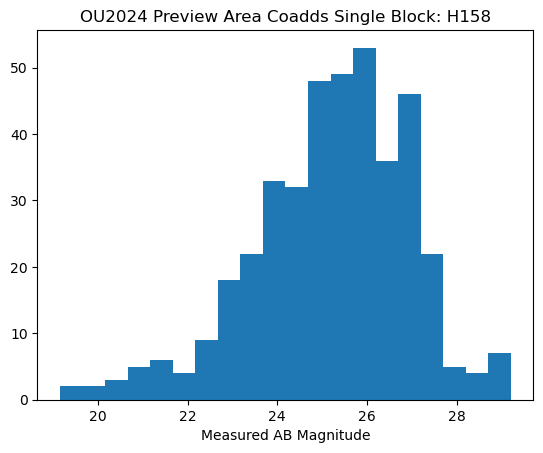

In [115]:
plt.hist(dict_results['mag_meta'], bins = 20)
plt.xlabel('Measured AB Magnitude')
plt.title('OU2024 Preview Area Coadds Single Block: H158')
plt.show()

### Loop over the entire preview data

Even though we can do this in the notebook, I think it better to run something bigger like this in a separate script.
See python code run_batch_metadetect.py for a script that does the same thing as above. Then parallelize or loop over the preview data blocks however you prefer. There is an example for how to run this in slurm for the CMU HPC, note that this may be different for your local HPC.

## Read generated catalogs for all OU24 preview blocks

Note that this will not run if you haven't run the code for all preview blocks. 
If you wish to only run a few you can change the code below as you see fit

In [36]:

def merge_parquet_dataframes(directory):
    # List all .parquet files in the directory
    parquet_files = [f for f in os.listdir(directory) if f.endswith('.parquet')]
    if not parquet_files:
        raise ValueError("No .parquet files found in directory.")

    dataframes = []
    for filename in parquet_files:
        filepath = os.path.join(directory, filename)
        df = pd.read_parquet(filepath)
        dataframes.append(df)

    # Concatenate all dataframes vertically
    merged_df = pd.concat(dataframes, ignore_index=True)

    return merged_df


In [118]:
## Merge all catalogs into one master catalog
directories = np.arange(12,24).astype(str)
merged_dfs = []
for direc in directories:
    merged_df = merge_parquet_dataframes('../runs/output/' + direc)
    merged_dfs.append(merged_df)
merged_df = pd.concat(merged_dfs, ignore_index=True)

In [121]:
merged_df#[:5]#[merged_df['edge_flag'] == 0]

,best_match_truth_id,ra_meta,dec_meta,flux_meta,mag_meta,edge_flag,flags,s2n,band_flux_flags
0,10307200062262,9.646843,-44.267298,0.000033,26.284571,1,0,0.837382,0
1,10307201257279,9.661324,-44.266733,0.000082,25.293709,1,0,2.085779,0
2,10307000486677,9.660364,-44.266768,0.000293,23.905391,1,0,7.491962,0
3,10307100848299,9.647002,-44.266707,0.000041,26.032576,1,0,1.056141,0
4,10307000486671,9.652562,-44.266732,0.000850,22.750592,1,0,21.702774,0
...,...,...,...,...,...,...,...,...,...
84534,10307100704498,9.591867,-43.932794,NaN,NaN,1,170917888,NaN,135266304
84535,10307100704498,9.591678,-43.932767,NaN,NaN,1,170917888,NaN,135266304
84536,10307201018157,9.623156,-43.932747,NaN,NaN,1,170917888,NaN,135266304
84537,10307101470815,9.618932,-43.932732,NaN,NaN,1,170917888,NaN,135266304


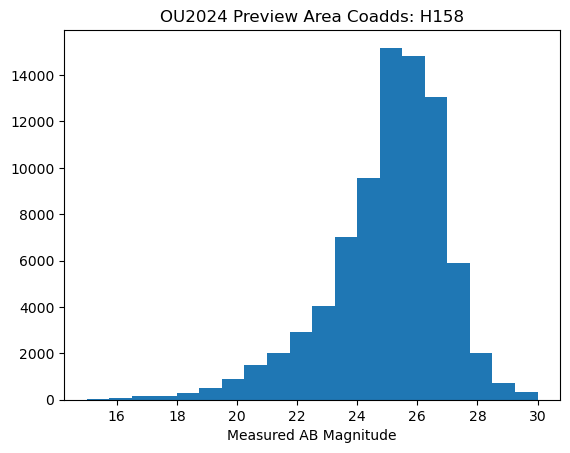

In [105]:
plt.hist(merged_df['mag_meta'], bins = 20, range = (15,30))
plt.xlabel('Measured AB Magnitude')
plt.title('OU2024 Preview Area Coadds: H158')
plt.show()

In [165]:
len(merged_df[merged_df['s2n'] > 10])/(400), len(merged_df[merged_df['edge_flag'] == 0])/(400)

(38.5725, 177.355)

In [119]:
len(np.unique(merged_df['best_match_truth_id']))

54436

In [74]:
filtered_flux = flux_cat[flux_cat['galaxy_id'].isin(merged_df['best_match_truth_id'])]
# Array of galaxy IDs (with duplicates)

# Turn into a DataFrame
id_df = pd.DataFrame({'galaxy_id': merged_df['best_match_truth_id']})

# Merge to preserve duplicates and order
filtered_flux = id_df.merge(flux_cat, on='galaxy_id', how='left')

roman_bandpasses = galsim.roman.getBandpasses()
zp = roman_bandpasses['H158'].zeropoint
flux_true_all = np.array(filtered_flux['roman_flux_H158'])
mag_true_all = -2.5*np.log10(flux_true_all) + zp

In [75]:
flux_meas_all, mags_meas_all = merged_df['flux_meta'], merged_df['mag_meta']

In [103]:
np.nanmedian(mags_meas_all/mag_true_all - 1), np.nanstd(mags_meas_all/mag_true_all - 1)

(np.float64(-0.00480247126814759), np.float64(0.08204910650594192))

In [131]:
np.nanmedian(flux_meas_all/flux_true_all - 1), np.nanstd(flux_meas_all/flux_true_all - 1)

(np.float64(0.10151688464122555), np.float64(10498.694605651033))

In [128]:
msk = np.logical_and(merged_df['edge_flag'] == 0 , merged_df['band_flux_flags'] == 0)
np.nanmedian((flux_meas_all/flux_true_all)[msk] - 1)

np.float64(0.09784000486664457)

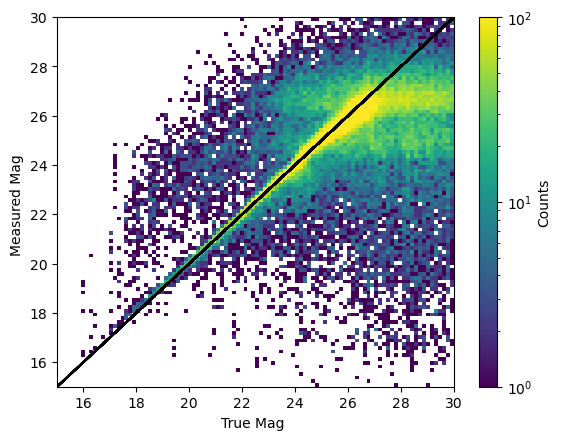

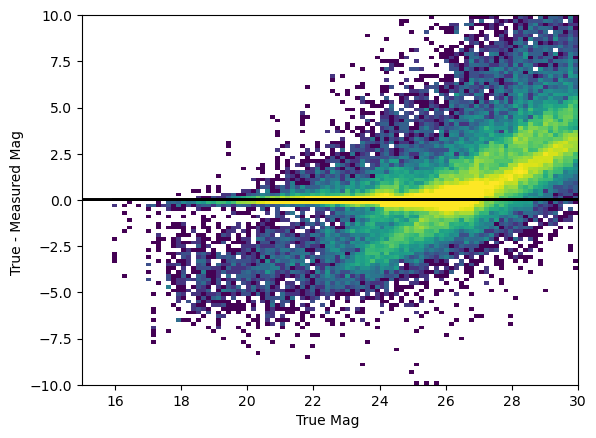

In [140]:
from matplotlib.colors import LogNorm

#msk = np.logical_and(merged_df['edge_flag'] == 0 , merged_df['band_flux_flags'] == 0)
plt.hist2d(
    mag_true_all,
    mags_meas_all,
    range=[[15, 30], [15, 30]],
    bins=(100, 100),
    norm=LogNorm(vmax=100),        # log color scale
)
#plt.scatter(mag_true_all, mags_meas_all )
plt.plot(mag_true_all,mag_true_all,color = 'black')
plt.xlabel('True Mag ')
plt.ylabel('Measured Mag ')
plt.colorbar(label='Counts')
plt.show()

plt.hist2d(
    mag_true_all,
    mag_true_all - mags_meas_all,
    range=[[15, 30], [-10, 10]],
    bins=(100, 100),
    norm=LogNorm(vmax=100),        # log color scale
)
#plt.scatter(mag_true_all,mag_true_all -  mags_meas_all )
plt.plot(mag_true_all,mag_true_all*0,color = 'black')

plt.xlabel('True Mag ')
plt.ylabel('True - Measured Mag ')
plt.show()

# Process all preview

In [29]:
all_img_paths = []
for subdir in subdirs:
    all_img_paths += fs.ls(subdir)

In [30]:
run_sim(all_img_paths[0], seed=42, mdet_seed=42, model="wmom", band=band)

(array([(-0.01047459, 0.01226554, 0.8499439, 0.98113245)],
       dtype=[('g1', '<f8'), ('g2', '<f8'), ('R11', '<f8'), ('R22', '<f8')]),
 array([(-0.03534738, 0.02819482, 0.84890712, 0.98209083)],
       dtype=[('g1', '<f8'), ('g2', '<f8'), ('R11', '<f8'), ('R22', '<f8')]),
 array([(-0.03619065, -0.00596436, 0.84770537, 0.98328118)],
       dtype=[('g1', '<f8'), ('g2', '<f8'), ('R11', '<f8'), ('R22', '<f8')]))

In [30]:
model = "wmom"
ntrial = len(all_img_paths)
# nsub = max(ntrial // 100, 10)
nsub = 16
nitr = ntrial // nsub
rng = np.random.RandomState(seed=116)
seeds = rng.randint(low=1, high=2**29, size=ntrial)
mdet_seeds = rng.randint(low=1, high=2**29, size=ntrial)

tm0 = time.time()

print("")

res7 = []
res8 = []
res9 = []
loc = 0
for itr in tqdm(range(nitr), total=nitr):
    jobs = [
        joblib.delayed(run_sim)(
            all_img_paths[loc+i],seeds[loc+i], mdet_seeds[loc+i], model,
        )
        for i in range(nsub)
    ]
    outputs = joblib.Parallel(n_jobs=4, verbose=0, backend='loky')(jobs)

    for out in outputs:
        if out is None:
            continue
        res7.append(out[0])
        res8.append(out[1])
        res9.append(out[2])
    loc += nsub

    m1, m1err, m2, m2err, c, cerr = boostrap_m_c(
        np.concatenate(res7),
        np.concatenate(res8),
        np.concatenate(res9),
    )
    print(
        (
            "\n"
            "nsims: %d\n"
            "m1 [1e-3, 3sigma]: %s +/- %s\n"
            "m2 [1e-3, 3sigma]: %s +/- %s\n"
            "c [1e-5, 3sigma]: %s +/- %s\n"
            "\n"
        ) % (
            len(res7),
            m1/1e-3,
            3*m1err/1e-3,
            m2/1e-3,
            3*m2err/1e-3,
            c/1e-5,
            3*cerr/1e-5,
        ),
        flush=True,
    )

total_time = time.time()-tm0
print("time per:", total_time/ntrial, flush=True)

  0%|          | 0/9 [00:00<?, ?it/s]


nsims: 16
m1 [1e-3, 3sigma]: -18.109637868460315 +/- 188.45086372385788
m2 [1e-3, 3sigma]: 27.27256638216824 +/- 149.18960349369235
c [1e-5, 3sigma]: 767.4235048161958 +/- 2977.9944991713937



nsims: 32
m1 [1e-3, 3sigma]: -45.53932341308142 +/- 155.50824765183145
m2 [1e-3, 3sigma]: 59.97651690626671 +/- 106.12273637284342
c [1e-5, 3sigma]: 1711.1087877075806 +/- 2233.29392619711



nsims: 48
m1 [1e-3, 3sigma]: -25.64025157103378 +/- 159.91917674923045
m2 [1e-3, 3sigma]: 14.476818117035384 +/- 110.4286818459892
c [1e-5, 3sigma]: 373.09076624932794 +/- 1835.7427711745656



nsims: 64
m1 [1e-3, 3sigma]: -30.39715116215702 +/- 146.23926754463264
m2 [1e-3, 3sigma]: 33.49537040256201 +/- 113.35099340259298
c [1e-5, 3sigma]: -27.933028647829108 +/- 1496.8348201966944




/Users/aguinot/miniconda3/envs/roman_sim/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



nsims: 80
m1 [1e-3, 3sigma]: -8.657798257084126 +/- 118.0337925804174
m2 [1e-3, 3sigma]: 30.801655897183977 +/- 92.36029741572084
c [1e-5, 3sigma]: -0.5561685796220466 +/- 1317.1309325532925



nsims: 96
m1 [1e-3, 3sigma]: 9.194399002939502 +/- 109.64056305266945
m2 [1e-3, 3sigma]: 16.158073912374782 +/- 78.2417893532744
c [1e-5, 3sigma]: -139.23969064791464 +/- 1199.4944444166258



nsims: 112
m1 [1e-3, 3sigma]: 10.91630202703886 +/- 97.31025100200263
m2 [1e-3, 3sigma]: 10.30253837256212 +/- 70.16399399275792
c [1e-5, 3sigma]: -257.77971085936554 +/- 1074.872347154749



nsims: 128
m1 [1e-3, 3sigma]: 17.87633450371473 +/- 92.77965542211469
m2 [1e-3, 3sigma]: 17.471350236955896 +/- 63.31733905058059
c [1e-5, 3sigma]: -174.60203231394323 +/- 961.7293021739196



nsims: 144
m1 [1e-3, 3sigma]: 18.293902449402655 +/- 81.34423102456535
m2 [1e-3, 3sigma]: 18.55417939686643 +/- 58.740234306890656
c [1e-5, 3sigma]: -117.96509366192161 +/- 969.6492652776494


time per: 24.782809381683666


In [31]:
res7 = np.concatenate(res7)
res8 = np.concatenate(res8)
res9 = np.concatenate(res9)
m1, m1err, m2, m2err, c, cerr = boostrap_m_c(
    res7,
    res8,
    res9,
)
print(
    (
        "\n"
        "nsims: %d\n"
        "m1 [1e-3, 3sigma]: %s +/- %s\n"
        "m2 [1e-3, 3sigma]: %s +/- %s\n"
        "c [1e-5, 3sigma]: %s +/- %s\n"
        "\n"
    ) % (
        len(res7),
        m1/1e-3,
        3*m1err/1e-3,
        m2/1e-3,
        3*m2err/1e-3,
        c/1e-5,
        3*cerr/1e-5,
    ),
    flush=True,
)


nsims: 144
m1 [1e-3, 3sigma]: 18.293902449402655 +/- 81.34423102456535
m2 [1e-3, 3sigma]: 18.55417939686643 +/- 58.740234306890656
c [1e-5, 3sigma]: -117.96509366192161 +/- 969.6492652776494


